## Descriptions:

Process height and weight
- Check H&W from flowsheet first. 
- Combined with H&W from demographics for processing. 
- They are in different units!
- Check for potential erroneous recorded measurements
- NOTE: missing recent_date but it doesn't matter


**Inputs**:  
- `6_3_coh2_demo` contains demographics and ESI
- `HWflowsheet_2021` contains queried HW from flowsheet

**Outputs**: 
* `6_4_coh2_demoHW` contains both demographics and H&W

### Importing R libraries

In [1]:
library(bigrquery)  # to query STARR-OMOP (stored in BigQuery) using SQL
library(tidyverse)
library(lubridate)

# library(data.table)
# library(Matrix)
# library(caret) # import this before glmnet to avoid rlang version problem
# library(glmnet)
# library(bit64)

# library(slam)
# library(mtools) for one hot coder, not available on Nero or use caret or tidyr
# library(mice)

options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




### Set up and run queries

In [2]:
# CREDENTIALS depending on LOCATIONS:
# credential <- paste0("/home/", "minh084", "/.config/gcloud/application_default_credentials.json")

# local computer
# credential <- "C:/Users/User/AppData/Roaming/gcloud/application_default_credentials.json"

# Nero onprem
# credential <- "/home/minh084/.config/gcloud/application_default_credentials.json"

# Nero gcp notebook
credential <- "/home/jupyter/.config/gcloud/application_default_credentials.json"

project_id <- "som-nero-phi-jonc101"

Sys.setenv(GOOGLE_APPLICATION_CREDENTIALS = credential)
Sys.setenv(GCLOUD_PROJECT = project_id)
gargle::credentials_app_default()

NULL

In [4]:
library(DBI)
con <- dbConnect(
  bigrquery::bigquery(),
  project = project_id,
  dataset = "shc_core_2021" #, billing = project_id
)
con 
dbListTables(con)

<BigQueryConnection>
  Dataset: som-nero-phi-jonc101.shc_core_2021
  Billing: som-nero-phi-jonc101

[1] "adt"                 "alert"               "alert_history"      
 [4] "alerts_orders"       "allergy"             "alt_com_action"     
 [7] "clinical_doc_meta"   "culture_sensitivity" "demographic"        
[10] "dep_map"             "diagnosis"           "drg_code"           
[13] "encounter"           "f_ip_hsp_admission"  "family_hx"          
[16] "flowsheet"           "lab_result"          "lda"                
[19] "med_orderset"        "myc_mesg"            "ndc_code"           
[22] "order_comment"       "order_med"           "order_proc"         
[25] "order_quest"         "pharmacy_mar"        "proc_note"          
[28] "proc_orderset"       "procedure"           "prov_map"           
[31] "social_hx"           "temp_table"          "treatment_team"     
[34] "yn_jon_chen_lpch"

### Use Flowsheet to get Height and Weight
- Height in inches and Weight in oz in flowsheet vs. cm and kg in demographics
    - Height(cm) = Height(inches) * 2.54 (in_2_cm)
    - Weight(kg) = Weight(oz) * 0.02835 (oz_2_kg)
- H&W in demographics are recent values, could be the latest from flowsheet, but not necessarily
- Explore H&W first, extract valid values for H&W from flowsheet
- Replace by NA invalid H&W from demographics.
- Merge them back together


In [6]:
# read inputs
datadir = "../../DataTD"
valdir = "../../OutputTD/6_validation"


cohort_demo <- read.csv(file.path(valdir, "6_3_coh2_demo.csv"))
hw <- read.csv(file.path(datadir, "HWflowsheet_2021.csv")) %>% 
        select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, row_disp_name,
               recorded_time = recorded_time_utc, num_value1, num_value2) 

# check for unique CSNs and MRNs
nrow(cohort_demo) #45796
nrow(hw) #depending on which cohort_demo used to query flowsheet 218930

nrow(cohort_demo %>% select(anon_id) %>% distinct()) #31513
nrow(hw %>% select(anon_id) %>% distinct())  #30152

nrow(cohort_demo %>% select(pat_enc_csn_id_coded) %>% distinct()) #45796
nrow(hw %>% select(pat_enc_csn_id_coded) %>% distinct()) #43609

# note that distinct CSNs are also distinct (MRNs and CSNs)
nrow(cohort_demo %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) #45796
nrow(hw %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) #43609

# cohort_demo %>% summarise(n_patients = n_distinct(anon_id))
# check num_value1 and num_value2
hw %>% group_by(row_disp_name) %>% count(sort=TRUE)

colnames(cohort_demo)
colnames(hw)

[1] 17131

[1] 84272

[1] 12993

[1] 12576

[1] 17131

[1] 16434

[1] 17131

[1] 16434

row_disp_name,n
<chr>,<int>
Weight,65742
Height,18530


[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time_jittered"     "label"                  
 [5] "admit_time"              "adm_year"               
 [7] "adm_month"               "inpatient_data_id_coded"
 [9] "ESI"                     "gender"                 
[11] "race"                    "recent_height_cm"       
[13] "recent_weight_kg"        "insurance"              
[15] "age"                     "English"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded" "row_disp_name"          
[5] "recorded_time"           "num_value1"             
[7] "num_value2"

In [7]:
# there's nothing in num_value2 for Height and Weight under flowsheet
# hw %>% group_by(row_disp_name, units) %>% summarise(count1 = length(num_value1), count2 = num_value2) %>% distinct()

hw %>% group_by(row_disp_name) %>% 
        summarise(n1 = length(num_value1[!is.na(num_value1)]), n2=length(num_value2[!is.na(num_value2)]))

summary(hw %>% select(num_value1, num_value2))

row_disp_name,n1,n2
<chr>,<int>,<int>
Height,18369,0
Weight,64633,0


   num_value1      num_value2    
 Min.   :    5.6   Mode:logical  
 1st Qu.: 1600.0   NA's:84272    
 Median : 2402.1                 
 Mean   : 2189.6                 
 3rd Qu.: 3012.4                 
 Max.   :19365.2                 
 NA's   :1270                    

In [8]:
# first, let's remove the num_value2 as nothing is in there
hw <- hw %>% select(-num_value2) %>% distinct()

# grab all duplicates columns with different num_value1 as these interferes with spread
hw[duplicated(hw[,1:5]) | duplicated(hw[,1:5], fromLast=TRUE), ] %>% 
    arrange(anon_id, pat_enc_csn_id_coded, recorded_time) 
# group_by(hw, colnames) %>% filter(n() > 1)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,row_disp_name,recorded_time,num_value1
<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
JC1791141,131316953812,70758033,Weight,2021-09-30 07:00:00+00:00,3414.48
JC1791141,131316953812,70758033,Weight,2021-09-30 07:00:00+00:00,3389.79
JC1798693,131318694459,71871780,Weight,2021-09-30 07:00:00+00:00,2119.94
JC1798693,131318694459,71871780,Weight,2021-09-30 07:00:00+00:00,2464.00
JC2034405,131317459401,71072456,Weight,2021-09-30 07:00:00+00:00,2742.40
JC2034405,131317459401,71072456,Weight,2021-09-30 07:00:00+00:00,2754.87
JC2665578,131320867656,73231043,Weight,2021-09-30 07:00:00+00:00,2391.55
JC2665578,131320867656,73231043,Weight,2021-09-30 07:00:00+00:00,2557.34
JC3061472,131319427789,72335784,Weight,2021-09-30 07:00:00+00:00,1920.00


In [9]:
# let's take the average of these values because they are very similar.
# Otherwise, if there are errors, remove them first. Spread to Height and Weight columns
hw <- hw %>% group_by(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, row_disp_name, recorded_time) %>%
            summarize(num_value1 = mean(num_value1, na.rm=TRUE)) %>% spread(row_disp_name, num_value1)
nrow(hw) #185645
colnames(hw)

`summarise()` has grouped output by 'anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'row_disp_name'. You can override using the `.groups` argument.



[1] 71145

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded" "recorded_time"          
[5] "Height"                  "Weight"

### Height and Weight
- Height in inches and Weight in oz in flowsheet vs. cm and kg in demographics
    - Height(cm) = Height(inches) * 2.54 (in_2_cm)
    - Weight(kg) = Weight(oz) * 0.02835 (oz_2_kg) 

- Aim to use flowsheet H&W as the source, closest time to admit time. 
    - Height: compare values within patients
    - Weight: compare values within encounters
- For missing H&W values, get replacements from demographics' H&W

In [10]:
# Height (fs vs. demo)
# recent_height_cm is likely the latest flowsheet height, all patients appear in flowsheet
hidfs <- hw %>% filter(!is.na(Height)) %>% distinct(pat_enc_csn_id_coded)
hiddm <- cohort_demo %>% filter(!is.na(recent_height_cm)) %>% distinct(pat_enc_csn_id_coded)

nrow(hidfs) #33608
nrow(hiddm) #44383 vs 44380

# we only care about the ids in cohort_demo, should be a subset of ids in flowsheet
length(hiddm$pat_enc_csn_id_coded %in% hidfs$pat_enc_csn_id_coded) #44383

[1] 12006

[1] 16744

[1] 16744

In [11]:
# Weight (fs vs. demo)
# recent_weight_kg is likely the latest flowsheet height, all patients appear in flowsheet
widfs <- hw %>% filter(!is.na(Weight)) %>% distinct(pat_enc_csn_id_coded) 
widdm <- cohort_demo %>% filter(!is.na(recent_weight_kg)) %>% distinct(pat_enc_csn_id_coded)

nrow(widfs) # 43213 vs 43211
nrow(widdm)
length(widdm$pat_enc_csn_id_coded %in% widfs$pat_enc_csn_id_coded)

[1] 16317

[1] 17101

[1] 17101

In [8]:
# nrow(left_join(cohort_demo, hw)) - nrow(left_join(cohort_demo, hw) %>% filter(is.na(Height), is.na(Weight))) #187832

In [13]:
# calculate time difference, by the minutes and days
# calculate difference in H&W of flowsheet and demographics, cm & kg
in_2_cm = 2.54
oz_2_kg = 0.02835

hw1 <- left_join(cohort_demo, hw) %>%  
                mutate(adredif = abs(as.numeric(difftime(admit_time, recorded_time, units = 'mins'))),
#                        dmfsdif = as.numeric(difftime(date(ymd(recent_date)), date(ymd_hms(recorded_time)), units = 'days')),
                       Hfsdmdif = abs(round(Height*2.54,2) - recent_height_cm),
                       Wfsdmdif = abs(round(Weight*0.02835,2) - recent_weight_kg)) #%>%
#                 group_by(anon_id, pat_enc_csn_id_coded) %>%
#                 filter(mindiff == min(mindiff)) %>% slice(1L) %>%
#                 filter_at(vars(Weight, Height), any_vars(!is.na(.))) # remove any rows that have both NA in H&W

# drop rows that have NA in both (Height and Weight)
# if there's NA, when widening the df, will have a NA col                
nrow(hw1) #187832 vs 187830

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded")



[1] 71842

In [14]:
# many weights recorded, some are errorenous
# check encounters with only 1 H&W vs. more than 1
# looks for Weight information within same encounter (e) # (and possibly same patient (p))

suppressWarnings(
hw1 <- hw1 %>% group_by(anon_id, pat_enc_csn_id_coded) %>% 
                mutate(nWe = length(Weight[!is.na(Weight)]),
                       minWe = min(Weight, na.rm=TRUE), maxWe = max(Weight, na.rm=TRUE),
                       rmaxWe = round(maxWe/Weight, 2)) #%>%
    
# nHe = length(Height[!is.na(Height)]),
# minHe = min(Height, na.rm=TRUE), maxHe = max(Height, na.rm=TRUE),
# rmaxHe = round(maxHe/Height, 2),
    
#                 group_by(anon_id) %>% 
#                 mutate(nWp = length(Weight[!is.na(Weight)]), nHp = length(Height[!is.na(Height)]),
#                        minW = min(Weight, na.rm=TRUE), maxW = max(Weight, na.rm=TRUE),
#                        rmaxWp = round(maxW/Weight, 2)) #%>% select(-'<NA>')
)

### Explore Height (from flowsheet, in inches): 
- Consider errors if Height < 45in (~ 114m) or > 90in (~2.2m)
- For the rest, get Height from flowsheet that is closest to Height from demographics, per patient, regardless of encounters

[1] 31

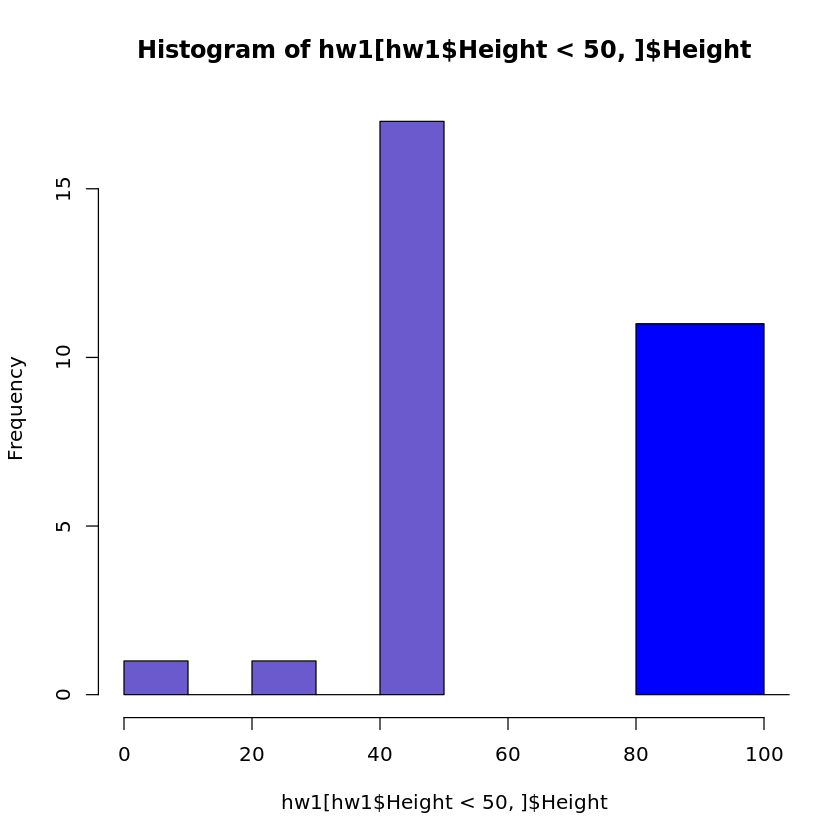

In [15]:
hist(hw1[hw1$Height < 50,]$Height, xlim=c(0, 100), col="slateblue") # remove < 40 (keep 42)
hist(hw1[hw1$Height > 80,]$Height, col="blue", add=TRUE) # remove > 85 or 90

errorH <- hw1 %>% filter(Height < 50 | Height > 80) %>% arrange(Height)
nrow(errorH)

In [17]:
# strict cut at 45 and 90
# recent_date, 
errorH %>% select(anon_id, pat_enc_csn_id_coded, recent_weight_kg, recent_height_cm, 
                  admit_time, recorded_time, Height)
dim(errorH)
colnames(errorH)

anon_id,pat_enc_csn_id_coded,recent_weight_kg,recent_height_cm,admit_time,recorded_time,Height
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
JC1698099,131315994500,104.20,167.64,2021-07-15 20:39:00,2021-07-15 16:37:00+00:00,5.600
JC2118528,131315197333,67.00,162.56,2021-07-23 20:58:00,2021-07-23 22:00:00+00:00,25.197
JC780539,131313982299,31.00,113.00,2021-07-29 04:55:00,2021-07-29 07:54:00+00:00,43.701
JC3238367,131319578393,99.50,170.18,2021-09-08 00:57:00,2021-09-07 20:46:00+00:00,44.094
JC589879,131293742400,66.20,114.80,2020-08-09 02:31:00,2020-09-03 15:20:00+00:00,45.197
JC589879,131293742400,66.20,114.80,2020-08-09 02:31:00,2020-08-09 06:00:00+00:00,45.200
JC589879,131293742400,66.20,114.80,2020-08-09 02:31:00,2020-08-09 01:32:00+00:00,45.276
JC2534196,131315983705,38.56,118.00,2021-09-04 16:48:00,2021-09-04 22:00:00+00:00,46.457
JC2775433,131293747518,71.90,121.90,2020-09-08 00:40:00,2020-09-08 19:00:00+00:00,47.992


[1] 31 26

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time_jittered"     "label"                  
 [5] "admit_time"              "adm_year"               
 [7] "adm_month"               "inpatient_data_id_coded"
 [9] "ESI"                     "gender"                 
[11] "race"                    "recent_height_cm"       
[13] "recent_weight_kg"        "insurance"              
[15] "age"                     "English"                
[17] "recorded_time"           "Height"                 
[19] "Weight"                  "adredif"                
[21] "Hfsdmdif"                "Wfsdmdif"               
[23] "nWe"                     "minWe"                  
[25] "maxWe"                   "rmaxWe"

#### Process Height from flowsheet, to merge with cohort_demo again later
- input `hw1`, output `h` = only all valid Heights available from flowsheet
- there are many recent_heights in  `cohort_demo` but not in flowsheet
- there are a few with valid Height in flowsheet with no valid recent_height in demographics (only care about CSNs in cohort_demo)

In [18]:
length(unique(cohort_demo$anon_id)) #31513
length(unique(hw1$anon_id)) #31513

# remove the most erroneous values and NAs under flowsheet
# take the closest values of flowsheet's Heights to Heights in demographics, per patients
h <- hw1 %>% filter(!is.na(Height), Height >= 45, Height <= 90) %>% group_by(anon_id) %>% slice(which.min(Hfsdmdif))
# group_by(anon_id) %>% slice_min(order_by = Hfsdmdif)

nrow(h) #24324
length(unique(h$anon_id)) #24324 vs 24323
length(unique(h$pat_enc_csn_id_coded)) #24324 

# those without H&W from demo
colSums(is.na(h[, c('Hfsdmdif', 'Wfsdmdif')]))

[1] 12993

[1] 12993

[1] 9757

[1] 9757

[1] 9757

Hfsdmdif Wfsdmdif 
       0     1941

In [19]:
# after processing, check for possible errors in a narrower range [45, 50) or (80, 90]
# recent_date, 
h %>% filter(Height < 50 | Height > 80) %>% arrange(Hfsdmdif, Height) %>%
        select(anon_id, pat_enc_csn_id_coded, recent_weight_kg, recent_height_cm, 
               admit_time, recorded_time, Height, Hfsdmdif)

anon_id,pat_enc_csn_id_coded,recent_weight_kg,recent_height_cm,admit_time,recorded_time,Height,Hfsdmdif
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
JC589879,131293742400,66.20,114.80,2020-08-09 02:31:00,2020-09-03 15:20:00+00:00,45.197,0.00
JC2534196,131315983705,38.56,118.00,2021-09-04 16:48:00,2021-09-04 22:00:00+00:00,46.457,0.00
JC2775433,131293747518,71.90,121.90,2020-09-08 00:40:00,2020-09-08 19:00:00+00:00,47.992,0.00
JC2945436,131290560594,45.13,122.00,2020-07-02 18:34:00,2020-07-02 22:30:00+00:00,48.031,0.00
JC3017216,131296061391,52.80,124.46,2020-10-24 21:42:00,2020-10-26 19:00:00+00:00,49.000,0.00
JC3038236,131298434781,33.50,124.50,2020-11-28 23:45:00,2020-12-08 15:59:00+00:00,49.016,0.00
JC1001688,131288774622,163.29,205.74,2020-06-19 21:36:00,2020-06-19 22:44:00+00:00,81.000,0.00
JC810540,131297135140,152.00,208.30,2020-11-12 17:16:00,2020-11-18 20:00:00+00:00,82.008,0.00
JC2024987,131316484878,90.72,213.36,2021-07-30 00:58:00,2021-07-29 23:32:00+00:00,84.000,0.00


In [21]:
# Height in flowsheets seem to be too low, take demographics' Height
nrow(h) 
h <- h %>% filter(!anon_id %in% checkH)
nrow(h) #

[1] 9757

[1] 9757

In [22]:
# remove invalid height in demo, compare counts, will not use this 
h_recent <- cohort_demo %>% filter(!is.na(recent_height_cm), recent_height_cm >=45*in_2_cm, recent_height_cm <=90*in_2_cm) 
length(unique(h_recent$anon_id)) #30139 vs 30136
length(unique(h$anon_id)) #24320

# patients with h from flowsheet but no valid recent_height
anti_join(h, h_recent, by=c("anon_id"))

# patients NO h from flowsheet but valid recent_height
nrow(anti_join(h_recent, h, by=c("anon_id")))

[1] 12613

[1] 9757

anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,admit_time,adm_year,adm_month,inpatient_data_id_coded,ESI,gender,race,recent_height_cm,recent_weight_kg,insurance,age,English,recorded_time,Height,Weight,adredif,Hfsdmdif,Wfsdmdif,nWe,minWe,maxWe,rmaxWe
<chr>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>


[1] 3110

In [24]:
# 12 patients within invalid recent_heights, many NAs, 
cohort_demo %>% filter(recent_height_cm < 45*in_2_cm | recent_height_cm > 90*in_2_cm) 

# this one has recent_height of 111cm, but Height = 67in = 170cm
# hw1 %>% filter(anon_id == 'JCdf7023')

anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,admit_time,adm_year,adm_month,inpatient_data_id_coded,ESI,gender,race,recent_height_cm,recent_weight_kg,insurance,age,English
<chr>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>
JC780539,1.31314e+11,2021-07-29 04:55:00+00:00,0,2021-07-29 04:55:00,2021,7,68877238,2,Female,Asian,113,31,1,62,1


### Explore Weight (from flowsheet, in ounces): 
- Consider errors and remove first
    - Weight > 12000 (12345.9 oz = 350kg) 
    - Weight < 720 (45lbs or 20.4kg)
- For the remaining Weights
    - see details under process Weight

In [25]:
summary(hw1$Weight) # 22046.00 is 625kg, 710 is about 20kg, 900 is about 25.5kg

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   77.1  2208.1  2648.0  2793.0  3200.0 19365.2    7215 

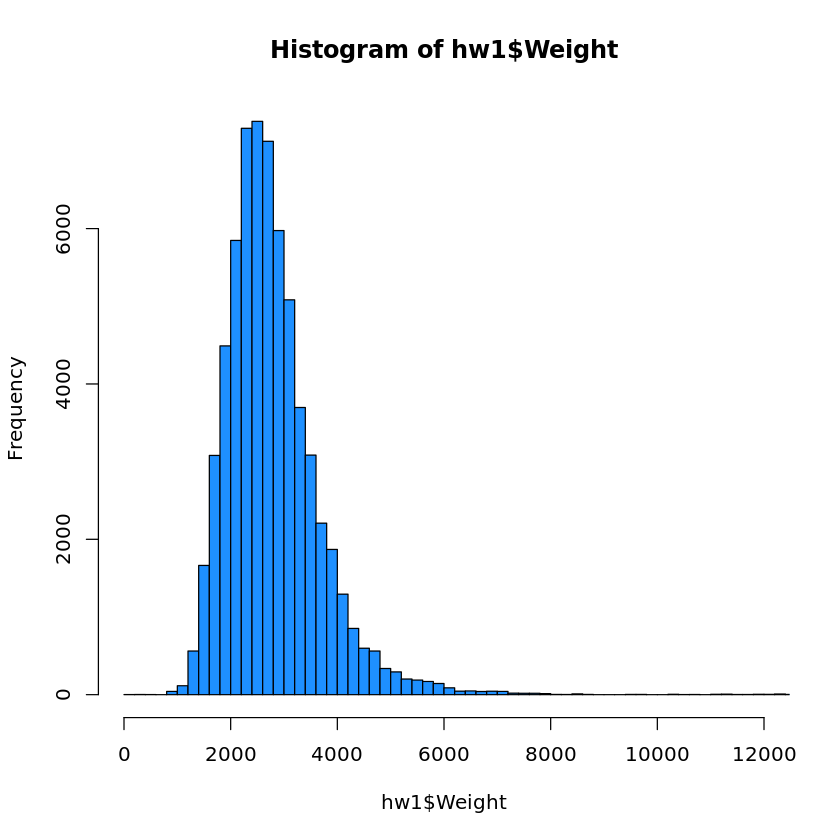

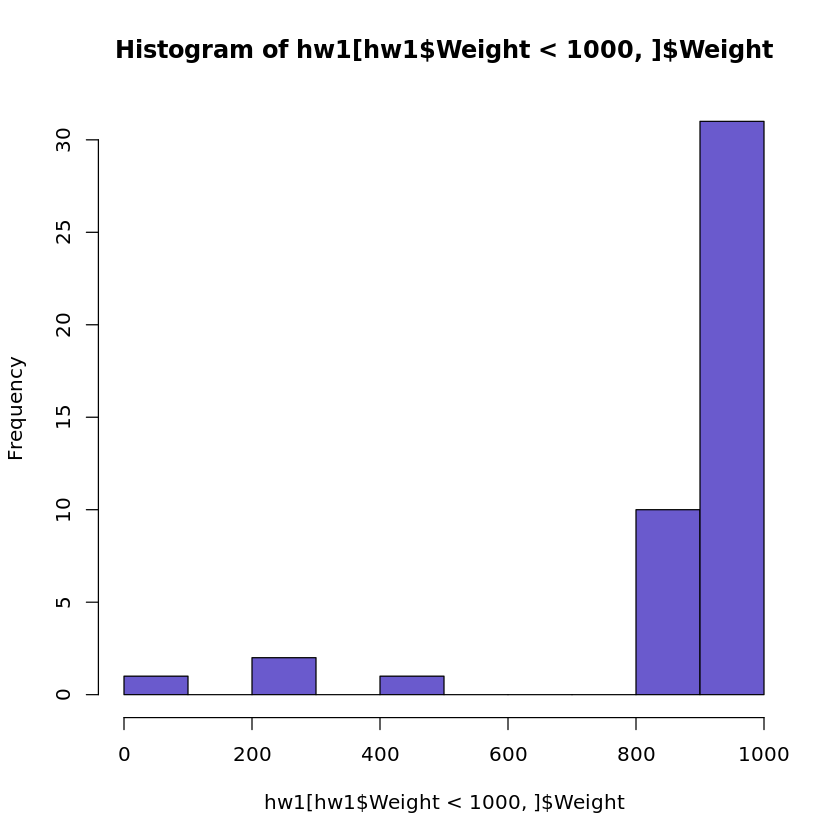

[1] 138

[1] 26

[1] 32

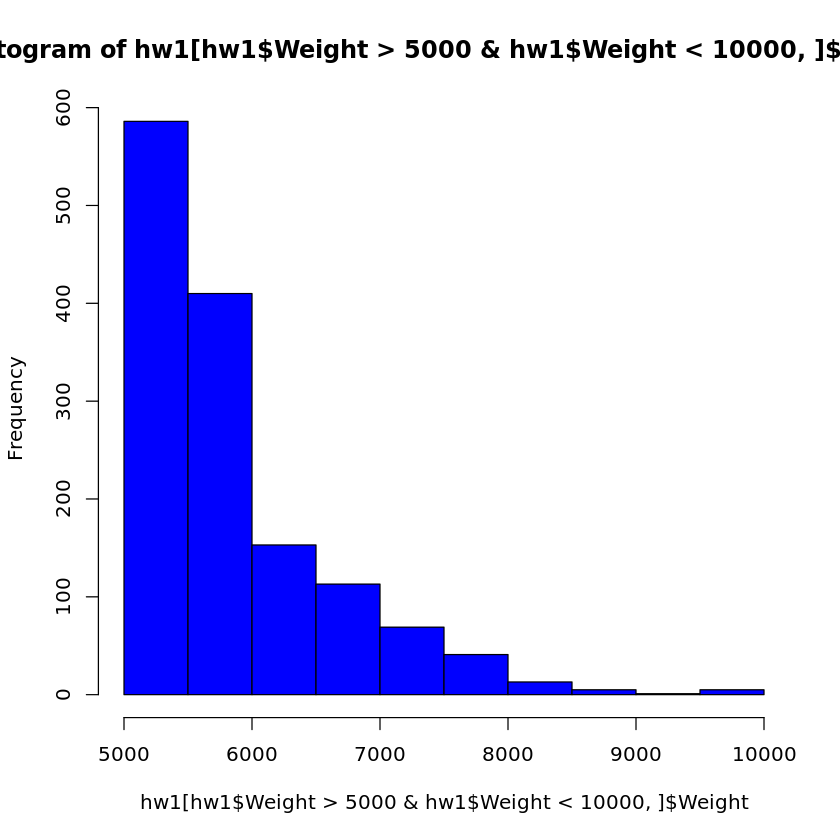

In [26]:
hist(hw1$Weight, breaks=100, xlim=c(0, 12000), col="dodgerblue")
hist(hw1[hw1$Weight < 1000,]$Weight, xlim=c(0,1000), col="slateblue") 
hist(hw1[hw1$Weight > 5000 & hw1$Weight < 10000,]$Weight, col="blue") 

# possible errors in Weight
errorW <- hw1 %>% filter(Weight < 1000 | Weight > 8000) %>% arrange(Weight)
nrow(errorW)

length(unique(errorW$anon_id))
length(unique(errorW$pat_enc_csn_id_coded))

In [28]:
errorW %>% select(anon_id, pat_enc_csn_id_coded, age, recent_height_cm, recent_weight_kg, 
                  admit_time, recorded_time, Weight, Wfsdmdif) %>% arrange(Weight)

anon_id,pat_enc_csn_id_coded,age,recent_height_cm,recent_weight_kg,admit_time,recorded_time,Weight,Wfsdmdif
<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
JC1519758,131304329212,64,162.56,84.30,2021-03-12 16:27:00,2021-03-12 11:49:00+00:00,77.10,82.11
JC1499635,131288946250,77,172.20,72.12,2020-06-15 23:05:00,2020-06-15 20:16:00+00:00,224.00,65.77
JC1702425,131318400414,48,170.18,72.57,2021-08-20 04:57:00,2021-08-20 01:24:00+00:00,256.00,65.31
JC2565128,131302299793,66,167.64,115.67,2021-01-13 07:26:00,2021-01-23 12:32:00+00:00,416.23,103.87
JC1476325,131310595451,54,144.80,26.76,2021-05-30 18:37:00,2021-06-04 15:00:00+00:00,857.15,2.46
JC1476325,131310595451,54,144.80,26.76,2021-05-30 18:37:00,2021-06-03 17:55:00+00:00,860.68,2.36
JC1549260,131318391387,30,158.50,28.98,2021-09-16 20:59:00,2021-09-20 12:42:00+00:00,860.68,4.58
JC1163658,131294628948,83,144.80,46.90,2020-09-21 05:39:00,2020-09-28 10:00:00+00:00,864.00,22.41
JC1476325,131310595451,54,144.80,26.76,2021-05-30 18:37:00,2021-06-02 00:00:00+00:00,874.79,1.96


In [29]:
# patients appear more than once in the errorW: 
# from the above cell and here: errors are < 720 and > 13000
# all look ok, except errors: 12381.03oz and 12024.77 
# (and possible errors # JCe36b60 9600.00 & 9770.79, but this is 1 special case, not big deal --> handle later)
# final: remove < 720 and > 12000
dup_errorW <- errorW[duplicated(errorW[,'anon_id']) | duplicated(errorW[,'anon_id'], fromLast=TRUE), ] %>% 
                    select(anon_id, pat_enc_csn_id_coded, age, recent_height_cm, recent_weight_kg, 
                           admit_time, recorded_time, Weight, nWe) %>% arrange(anon_id, recorded_time)

length(unique(dup_errorW$anon_id))
dup_errorW

[1] 16

anon_id,pat_enc_csn_id_coded,age,recent_height_cm,recent_weight_kg,admit_time,recorded_time,Weight,nWe
<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
JC1476325,131306560913,54,144.80,26.76,2021-04-08 04:57:00,2021-04-08 06:29:00+00:00,932.80,1
JC1476325,131310595451,54,144.80,26.76,2021-05-30 18:37:00,2021-05-31 18:00:00+00:00,928.00,9
JC1476325,131310595451,54,144.80,26.76,2021-05-30 18:37:00,2021-06-01 01:06:00+00:00,920.00,9
JC1476325,131310595451,54,144.80,26.76,2021-05-30 18:37:00,2021-06-02 00:00:00+00:00,874.79,9
JC1476325,131310595451,54,144.80,26.76,2021-05-30 18:37:00,2021-06-03 17:55:00+00:00,860.68,9
JC1476325,131310595451,54,144.80,26.76,2021-05-30 18:37:00,2021-06-04 15:00:00+00:00,857.15,9
JC1476325,131310595451,54,144.80,26.76,2021-05-30 18:37:00,2021-06-06 22:48:00+00:00,903.00,9
JC1476325,131310595451,54,144.80,26.76,2021-05-30 18:37:00,2021-06-08 15:14:00+00:00,952.39,9
JC1476325,131310595451,54,144.80,26.76,2021-05-30 18:37:00,2021-06-10 06:23:00+00:00,931.20,9


In [31]:
# these patients appeared once in errorW, so likely all errors 
# verify in the next cell, check for possible correct values (<1000 or >8000)
non_dup_errorW <- errorW %>% filter(!anon_id %in% dup_errorW$anon_id) %>%
                                select(anon_id, pat_enc_csn_id_coded, age, recent_height_cm, recent_weight_kg, 
                                       admit_time, recorded_time, Weight, nWe, Wfsdmdif) %>% arrange(Weight) 

length(unique(non_dup_errorW$anon_id))
non_dup_errorW

[1] 10

anon_id,pat_enc_csn_id_coded,age,recent_height_cm,recent_weight_kg,admit_time,recorded_time,Weight,nWe,Wfsdmdif
<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
JC1519758,131304329212,64,162.56,84.30,2021-03-12 16:27:00,2021-03-12 11:49:00+00:00,77.10,7,82.11
JC1499635,131288946250,77,172.20,72.12,2020-06-15 23:05:00,2020-06-15 20:16:00+00:00,224.00,4,65.77
JC1702425,131318400414,48,170.18,72.57,2021-08-20 04:57:00,2021-08-20 01:24:00+00:00,256.00,2,65.31
JC2565128,131302299793,66,167.64,115.67,2021-01-13 07:26:00,2021-01-23 12:32:00+00:00,416.23,28,103.87
JC1163658,131294628948,83,144.80,46.90,2020-09-21 05:39:00,2020-09-28 10:00:00+00:00,864.00,5,22.41
JC2495489,131314894904,22,147.32,29.03,2021-07-07 06:44:00,2021-07-07 04:09:00+00:00,938.28,1,2.43
JC640050,131297661223,43,152.40,33.30,2020-11-11 21:33:00,2020-11-12 01:42:00+00:00,980.80,2,5.49
JC1486806,131305386128,41,167.00,213.70,2021-03-14 10:09:00,2021-03-14 12:00:00+00:00,8108.80,6,16.18
JC3214717,131314577085,33,200.66,247.66,2021-07-25 13:24:00,2021-07-25 09:23:00+00:00,8640.00,1,2.72


In [32]:
# verify the above are errors! 
# look for possible valid values that are < 1000 or  > 8000 --> ok to remove all except JCd0500f of 987.66 might be valid
eW2 <- non_dup_errorW %>% filter(Weight > 720, Weight < 12000) # within (720, 1000) & (8000, 12000)
hw1 %>% filter(anon_id %in% eW2$anon_id, !is.na(Weight)) %>% 
        select(anon_id, pat_enc_csn_id_coded, age, recent_height_cm, recent_weight_kg, 
               admit_time, recorded_time, Weight, nWe) %>% arrange(anon_id, recorded_time)

anon_id,pat_enc_csn_id_coded,age,recent_height_cm,recent_weight_kg,admit_time,recorded_time,Weight,nWe
<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
JC1163658,131294628948,83,144.80,46.90,2020-09-21 05:39:00,2020-09-20 23:57:00+00:00,1600.00,5
JC1163658,131294628948,83,144.80,46.90,2020-09-21 05:39:00,2020-09-21 07:15:00+00:00,1808.00,5
JC1163658,131294628948,83,144.80,46.90,2020-09-21 05:39:00,2020-09-28 07:15:00+00:00,1992.96,5
JC1163658,131294628948,83,144.80,46.90,2020-09-21 05:39:00,2020-09-28 10:00:00+00:00,864.00,5
JC1163658,131294628948,83,144.80,46.90,2020-09-21 05:39:00,2020-09-29 04:00:00+00:00,1985.90,5
JC1486806,131294824051,41,167.00,213.70,2020-09-23 01:15:00,2020-09-22 20:48:00+00:00,7866.01,7
JC1486806,131294824051,41,167.00,213.70,2020-09-23 01:15:00,2020-09-23 04:00:00+00:00,7442.73,7
JC1486806,131294824051,41,167.00,213.70,2020-09-23 01:15:00,2020-09-27 13:00:00+00:00,7347.49,7
JC1486806,131294824051,41,167.00,213.70,2020-09-23 01:15:00,2020-09-28 13:00:00+00:00,7326.33,7


#### Process Weight
input `hw1`, output `w`
- remove <720 and >12000
- remove those with only 1 value in (<1000 and >8000) but have other values in [1000, 80000]
- more difficult with Weights within 1000 and 8000 but have large differences:
    - take the average of other weights of the same encounters but not the exact value at evaluation, *X(-i)* or *avg_Xself*
    - get ratio different of self/average not self, *r_avg_Xself*
    - if one value, take it (*avg_Xself* = NaN) --> `w1`
    - if 2 values, take average (*r_avg_Xself* = 1) --> `w2`
    - if 3 or more: get the first 3 closest to admit_time, then pick the one with *r_avg_Xself* closest to 1 --> `w3`

In [34]:
length(unique(cohort_demo$pat_enc_csn_id_coded)) #45796
length(unique(hw1$pat_enc_csn_id_coded)) #45796

# remove erroneous values and NAs first, retain only patients with possible valid Weight under flowsheet
w <- hw1 %>% filter(Weight >= 720, Weight <= 12000, !is.na(Weight)) %>% anti_join(eW2)

length(unique(w$pat_enc_csn_id_coded)) #43211 vs 43209
colnames(w)

[1] 17131

[1] 17131

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "recent_height_cm", "recent_weight_kg", "age", "recorded_time", "Weight", "Wfsdmdif", "nWe")



[1] 16315

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time_jittered"     "label"                  
 [5] "admit_time"              "adm_year"               
 [7] "adm_month"               "inpatient_data_id_coded"
 [9] "ESI"                     "gender"                 
[11] "race"                    "recent_height_cm"       
[13] "recent_weight_kg"        "insurance"              
[15] "age"                     "English"                
[17] "recorded_time"           "Height"                 
[19] "Weight"                  "adredif"                
[21] "Hfsdmdif"                "Wfsdmdif"               
[23] "nWe"                     "minWe"                  
[25] "maxWe"                   "rmaxWe"

In [35]:
# within the same patients, same encounters:
# recalculate count/max/ratio of W to max W/ratio of W over average not self Weight... 
w <- w %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, age, recent_weight_kg, 
                  admit_time, recorded_time, Weight, Wfsdmdif) %>% 
            group_by(anon_id, pat_enc_csn_id_coded) %>% 
            mutate(nWe =length(Weight[!is.na(Weight)]), maxWe = max(Weight, na.rm=TRUE), rmaxWe = round(maxWe/Weight, 2), 
                   avg_Xself= round((sum(Weight)-Weight)/(nWe-1),2),
                   r_avg_Xself= round(Weight/avg_Xself, 2)) %>%
#             mutate(d_avg_Xself = ifelse(is.na(d_avg_Xself), 1, d_avg_Xself)) %>%
            arrange(anon_id, pat_enc_csn_id_coded, r_avg_Xself)
summary(w)

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:64578       Min.   :1.313e+11    Min.   :51823319       
 Class :character   1st Qu.:1.313e+11    1st Qu.:56955957       
 Mode  :character   Median :1.313e+11    Median :61862157       
                    Mean   :1.313e+11    Mean   :62164287       
                    3rd Qu.:1.313e+11    3rd Qu.:67457466       
                    Max.   :1.313e+11    Max.   :73231043       
                                                                
      age         recent_weight_kg  admit_time        recorded_time     
 Min.   : 18.00   Min.   : 26.76   Length:64578       Length:64578      
 1st Qu.: 48.00   1st Qu.: 61.69   Class :character   Class :character  
 Median : 62.00   Median : 74.20   Mode  :character   Mode  :character  
 Mean   : 60.26   Mean   : 77.85                                        
 3rd Qu.: 73.00   3rd Qu.: 89.90                                        
 Max.   :107.00   Max.   :342.46          

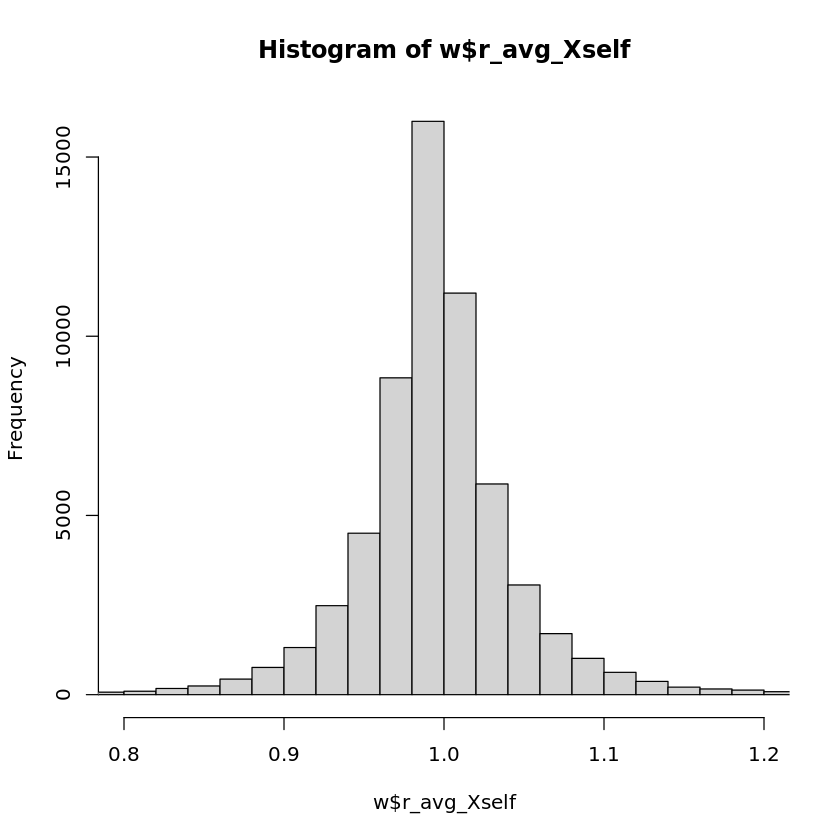

In [36]:
hist(w$r_avg_Xself, xlim=c(0.8, 1.2), breaks=100)

In [37]:
# extract Weights depending on scenarios of how many available Weights per encounters
w1 <- w %>% filter(nWe == 1)
w2 <- w %>% filter(nWe == 2) %>% group_by(anon_id, pat_enc_csn_id_coded) %>% mutate(Weight = mean(Weight)) %>% # no NA here
        arrange(anon_id, pat_enc_csn_id_coded, Weight) %>% slice(1L) # take one if both are the same
w3 <- w %>% filter(nWe > 2) %>% arrange(anon_id, pat_enc_csn_id_coded, recorded_time) %>% slice(1:3) %>%
        mutate(d1 = abs(r_avg_Xself-1)) %>% # difference of r_avg_Xself to 1, from either sides
        arrange(anon_id, pat_enc_csn_id_coded, d1) %>% slice(1L) # take the first closest to 1

nrow(w1) #12004 vs 12002
length(unique(w1$pat_enc_csn_id_coded))
nrow(w2) #9897
nrow(w %>% filter(nWe == 2) %>% distinct(pat_enc_csn_id_coded))
nrow(w3) #21310
nrow(w %>% filter(nWe > 2) %>% distinct(pat_enc_csn_id_coded))

[1] 4834

[1] 4834

[1] 4157

[1] 4157

[1] 7324

[1] 7324

In [38]:
nrow(w1) + nrow(w2) + nrow(w3) #43211 vs 43209
combinedW <- full_join(w1, w2) %>% full_join (w3)
nrow(combinedW)
length(unique(combinedW$pat_enc_csn_id_coded))

[1] 16315

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "age", "recent_weight_kg", "admit_time", "recorded_time", "Weight", "Wfsdmdif", "nWe", "maxWe", "rmaxWe", "avg_Xself", "r_avg_Xself")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "age", "recent_weight_kg", "admit_time", "recorded_time", "Weight", "Wfsdmdif", "nWe", "maxWe", "rmaxWe", "avg_Xself", "r_avg_Xself")



[1] 16315

[1] 16315

In [40]:
# remove invalid weight in demo, compare counts, will not use this for merging as it remove patients from the cohort_demo
# no invalid recent_weight, only NA
w_recent <- cohort_demo %>% filter(recent_weight_kg >= 720*oz_2_kg, recent_weight_kg <= 12000*oz_2_kg, !is.na(recent_weight_kg))

length(unique(w_recent$pat_enc_csn_id_coded)) #45482
length(unique(combinedW$pat_enc_csn_id_coded)) #43211

# patients with w from flowsheet but no valid recent_weight
nrow(anti_join(combinedW, w_recent, by=c("pat_enc_csn_id_coded"))) #46

# patients NO w from flowsheet but valid recent_weight
nrow(anti_join(w_recent, combinedW, by=c("pat_enc_csn_id_coded"))) #2317

[1] 17100

[1] 16315

[1] 1

[1] 786

### Combine Height and Weight with demogrpahic table
- Weight in kg and Height in cm
- Combine valid H&W dataframes from flowsheet
- Merge with original cohort_demo to make sure we have all cohort
- Replace errorneous values in cohort_demo as NA
    - Height < 45 * in_2_cm & >  90 * in_2_cm --> NA
    - Weight < 720 * oz_2_kg & > 12000 * oz_2_kg --> NA
- If no H&W in flowsheet, use the one from demographics (recent H&W)

In [41]:
# patients NO h from flowsheet but valid recent_height
nrow(anti_join(h_recent, h, by=c("anon_id"))) #6270 vs 6268
length(unique(h_recent$anon_id)) #30139 vs 30136
colnames(h)

# patients NO w from flowsheet but valid recent_weight
nrow(anti_join(w_recent, combinedW, by=c("anon_id"))) #1342
length(unique(w_recent$pat_enc_csn_id_coded)) #45482
colnames(combinedW)

[1] 3110

[1] 12613

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time_jittered"     "label"                  
 [5] "admit_time"              "adm_year"               
 [7] "adm_month"               "inpatient_data_id_coded"
 [9] "ESI"                     "gender"                 
[11] "race"                    "recent_height_cm"       
[13] "recent_weight_kg"        "insurance"              
[15] "age"                     "English"                
[17] "recorded_time"           "Height"                 
[19] "Weight"                  "adredif"                
[21] "Hfsdmdif"                "Wfsdmdif"               
[23] "nWe"                     "minWe"                  
[25] "maxWe"                   "rmaxWe"

[1] 468

[1] 17100

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "age"                    
 [5] "recent_weight_kg"        "admit_time"             
 [7] "recorded_time"           "Weight"                 
 [9] "Wfsdmdif"                "nWe"                    
[11] "maxWe"                   "rmaxWe"                 
[13] "avg_Xself"               "r_avg_Xself"            
[15] "d1"

In [42]:
# combine valid H&W from flowsheet
fsH <- h %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, Height)
fsW <- combinedW %>% select(anon_id, pat_enc_csn_id_coded, Weight)

fsHW <- full_join(fsH, fsW)
nrow(fsHW) #43462
length(unique(fsHW$pat_enc_csn_id_coded)) #43462

Joining, by = c("anon_id", "pat_enc_csn_id_coded")



[1] 16403

[1] 16403

In [43]:
# check cohort_demo, with H and W already removed erroneous values
# cohort_demo <- read.csv(file.path(featuredir, "2_1_coh2_demo.csv"))

nrow(cohort_demo) #45794
length(unique(cohort_demo$anon_id)) #31511
length(unique(cohort_demo$pat_enc_csn_id_coded)) #45794

summary(cohort_demo %>% select(recent_height_cm, recent_weight_kg))

nrow(cohort_demo %>% filter(recent_height_cm < 45*in_2_cm | recent_height_cm >  90*in_2_cm)) #12
nrow(cohort_demo %>% filter(recent_weight_kg < 720*oz_2_kg | recent_weight_kg > 12000*oz_2_kg)) #4

# replace cohort_demo H&W with NA for the bad
cohort_demo <- cohort_demo %>% mutate(recent_height_cm = ifelse(recent_height_cm < 45*in_2_cm | recent_height_cm > 90*in_2_cm, 
                                                     NA, recent_height_cm),
                                      recent_weight_kg = ifelse(recent_weight_kg < 720*oz_2_kg | recent_weight_kg > 12000*oz_2_kg, 
                                                     NA, recent_weight_kg))

summary(cohort_demo %>% select(recent_height_cm, recent_weight_kg))

# patients in flowsheet but no matching in demographics: all fs are in cohort_demo
nrow(anti_join(fsHW, cohort_demo, by=c("anon_id", "pat_enc_csn_id_coded"))) #0
colnames(fsHW)
colnames(cohort_demo)

[1] 17131

[1] 12993

[1] 17131

 recent_height_cm recent_weight_kg
 Min.   :113.0    Min.   : 26.76  
 1st Qu.:160.0    1st Qu.: 61.23  
 Median :167.6    Median : 74.00  
 Mean   :168.0    Mean   : 77.21  
 3rd Qu.:175.3    3rd Qu.: 88.50  
 Max.   :213.4    Max.   :342.46  
 NA's   :387      NA's   :30      

[1] 1

[1] 1

 recent_height_cm recent_weight_kg
 Min.   :114.8    Min.   : 26.76  
 1st Qu.:160.0    1st Qu.: 61.23  
 Median :167.6    Median : 74.00  
 Mean   :168.0    Mean   : 77.20  
 3rd Qu.:175.3    3rd Qu.: 88.50  
 Max.   :213.4    Max.   :321.00  
 NA's   :388      NA's   :31      

[1] 0

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded" "Height"                 
[5] "Weight"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time_jittered"     "label"                  
 [5] "admit_time"              "adm_year"               
 [7] "adm_month"               "inpatient_data_id_coded"
 [9] "ESI"                     "gender"                 
[11] "race"                    "recent_height_cm"       
[13] "recent_weight_kg"        "insurance"              
[15] "age"                     "English"

In [44]:
cohort_hw <- left_join(cohort_demo, fsHW) %>% 
                group_by(anon_id, pat_enc_csn_id_coded) %>%
                mutate(Height = ifelse(is.na(Height), recent_height_cm, round(Height * in_2_cm, 0)),
                       Weight = ifelse(is.na(Weight), recent_weight_kg, round(Weight * oz_2_kg, 0))) 

nrow(cohort_hw) #45794 last
length(unique(cohort_hw$anon_id)) #31511
length(unique(cohort_hw$pat_enc_csn_id_coded)) #45794

# the distributions are pretty close. this is good. 
summary(cohort_hw %>% select(Height, Weight, recent_height_cm, recent_weight_kg))

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded")



[1] 17131

[1] 12993

[1] 17131

Adding missing grouping variables: `anon_id`, `pat_enc_csn_id_coded`



   anon_id          pat_enc_csn_id_coded     Height          Weight      
 Length:17131       Min.   :1.313e+11    Min.   :115.0   Min.   : 25.00  
 Class :character   1st Qu.:1.313e+11    1st Qu.:160.0   1st Qu.: 61.87  
 Mode  :character   Median :1.313e+11    Median :168.0   Median : 74.00  
                    Mean   :1.313e+11    Mean   :168.1   Mean   : 77.66  
                    3rd Qu.:1.313e+11    3rd Qu.:175.3   3rd Qu.: 89.00  
                    Max.   :1.313e+11    Max.   :213.0   Max.   :322.00  
                                         NA's   :388     NA's   :30      
 recent_height_cm recent_weight_kg
 Min.   :114.8    Min.   : 26.76  
 1st Qu.:160.0    1st Qu.: 61.23  
 Median :167.6    Median : 74.00  
 Mean   :168.0    Mean   : 77.20  
 3rd Qu.:175.3    3rd Qu.: 88.50  
 Max.   :213.4    Max.   :321.00  
 NA's   :388      NA's   :31      

In [45]:
head(cohort_hw)

anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,admit_time,adm_year,adm_month,inpatient_data_id_coded,ESI,gender,race,recent_height_cm,recent_weight_kg,insurance,age,English,Height,Weight
<chr>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,2020-09-29 22:45:00,2020,9,57868578,3,Female,Other,154.00,73.05,1,44,0,154.00,73.05
JC1000939,131295018112,2020-08-22 11:41:00+00:00,1,2020-08-22 11:41:00,2020,8,57698292,2,Female,Other,154.94,136.80,1,49,0,156.00,134.00
JC1001580,131300665918,2020-12-29 04:15:00+00:00,0,2020-12-29 04:15:00,2020,12,61108864,3,Male,White,187.96,89.12,1,54,1,188.00,89.00
JC1001688,131288774622,2020-06-19 21:36:00+00:00,0,2020-06-19 21:36:00,2020,6,53810016,3,Male,Asian,205.74,163.29,0,37,1,206.00,163.00
JC1001688,131302440087,2021-02-26 11:46:00+00:00,0,2021-02-26 11:46:00,2021,2,62198093,3,Male,Asian,205.74,163.29,0,37,1,205.74,163.29
JC1001842,131305861173,2021-02-23 08:08:00+00:00,0,2021-02-23 08:08:00,2021,2,64314745,3,Male,Other,170.18,63.50,1,20,1,170.18,63.50


In [46]:
# save file, this has all processed variables from demographics and processed HW from flowsheet
# cohort_demoHW
cohort_hw <- cohort_hw %>% select(-recent_height_cm, -recent_weight_kg)
write.csv(cohort_hw, file.path(valdir, "6_4_coh2_demoHW.csv"), row.names=FALSE)